## Building GRUs with PyTorch

Today we are going to build GRUs from scratch using PyTorch.

We'll implement the core GRUs cell and create a multi-layered model, gaining a deep understanding of how GRUs process sequential data.

**Below information and images are mainly collected from below articles and references:**
    
- [Understanding Gated Recurrent Unit (GRU) in Deep Learning](https://medium.com/@anishnama20/understanding-gated-recurrent-unit-gru-in-deep-learning-2e54923f3e2)
    


In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

c:\Users\PC\anaconda3\envs\torch_gpuenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
# Prepairing the MNIST dataset
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
 
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


In [3]:
img, label = next(iter(train_loader))
img.shape, label.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [4]:
classes = train_dataset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

# Building The Model

## Demystifying the GRU Architecture

The Gated Recurrent Unit (GRU) architecture is a powerful tool for handling sequential data. Here's a breakdown of its key components:

**1. Input Layer:**
  - This layer acts as the entry point, receiving sequential data like words in a sentence or values in a time series. It feeds this data into the core GRU unit.

**2. Hidden Layer:**
  - This is the heart of the GRU, where the magic happens. At each time step, the hidden state is updated based on two things:
     - The current input from the input layer.
     - The previous hidden state, which essentially represents the network's "memory" of what it has seen so far.

**3. Reset Gate:**
  - This gate acts like a selective memory eraser. It takes the previous hidden state and the current input as inputs and outputs a value between 0 and 1. 
     - A value closer to 1 signifies "forgetting" more of the previous hidden state, while a value near 0 indicates retaining most of it.

**4. Update Gate:**
  - This gate is the information control center. It determines how much of a newly proposed "candidate activation" (explained next) to incorporate into the new hidden state. Similar to the reset gate, it takes the previous hidden state and current input, outputting values between 0 and 1.

**5. Candidate Activation Vector:**
  - This vector proposes a new hidden state based on the current input and a "reset" version of the previous hidden state (influenced by the reset gate). It's calculated using a tanh activation function, limiting its output between -1 and 1.

**6. Output Layer (not shown in code):**
  - While not explicitly shown in the provided code, the final hidden state is typically fed into an output layer. This layer's output format depends on the task: a single number, a sequence of numbers, or even a probability distribution.

By using these components, GRUs can effectively learn long-term dependencies within sequential data, making them valuable tools for various applications. 

<img src='/images/gru_archi.png'>

In [5]:
class GRUCell(nn.Module):
    """
    Implements a Gated Recurrent Unit (GRU) cell for processing sequential data.

    Args:
        input_size (int): Dimensionality of the input data.
        hidden_size (int): Dimensionality of the hidden state.
        bias (bool, optional): Whether to include bias terms in the linear layers. Defaults to True.
    """

    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # Linear layers for transforming input (x) and hidden state (h)
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)

        # Reset parameters for weight initialization
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initializes the weights of the linear layers using a uniform distribution.
        """
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        """
        Performs the forward pass of the GRU cell, updating the hidden state based on the current input and previous hidden state.

        Args:
            x (torch.Tensor): Input data of shape (batch_size, input_size).
            hidden (torch.Tensor): Previous hidden state of shape (batch_size, hidden_size).

        Returns:
            torch.Tensor: Updated hidden state of shape (batch_size, hidden_size).
        """

        # Reshape input to ensure batch dimension is first (if needed)
        x = x.view(-1, x.size(1))

        # Combine transformations of input (gate_x) and hidden state (gate_h)
        gate_x = self.x2h(x)  # (batch_size, 3 * hidden_size)
        gate_h = self.h2h(hidden)  # (batch_size, 3 * hidden_size)

        # Remove unnecessary dimensions
        gate_x = gate_x.squeeze()  # (batch_size, 3 * hidden_size)
        gate_h = gate_h.squeeze()  # (batch_size, 3 * hidden_size)

        # Split combined gates into reset, update, and new gate information for cell and hidden state
        i_r, i_i, i_n = gate_x.chunk(3, 1)  # (batch_size, hidden_size) each
        h_r, h_i, h_n = gate_h.chunk(3, 1)  # (batch_size, hidden_size) each

        # Calculate reset gate using sigmoid activation
        resetgate = torch.sigmoid(i_r + h_r)  # (batch_size, hidden_size)

        # Calculate update gate using sigmoid activation
        updategate = torch.sigmoid(i_i + h_i)  # (batch_size, hidden_size)

        # Calculate candidate activation vector using tanh activation
        candidate_activation_vector = torch.tanh(i_n + (resetgate * h_n))  # (batch_size, hidden_size)

        # Update hidden state using candidate activation and update gate
        hy = candidate_activation_vector + updategate * (hidden - candidate_activation_vector)  # (batch_size, hidden_size)

        return hy


In [6]:
class GRUModel(nn.Module):
    """
    Implements a model using a multi-layer GRU architecture for sequential data.

    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden state.
        layer_dim (int): Number of GRU layers.
        output_dim (int): Dimensionality of the output.
        bias (bool, optional): Whether to include bias terms in linear layers. Defaults to True.
    """

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(GRUModel, self).__init__()

        # Store model configuration
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # Create GRU layers
        self.gru_cells = nn.ModuleList([GRUCell(input_dim, hidden_dim, bias) for _ in range(layer_dim)])

        # Final fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Performs the forward pass of the model.

        Args:
            x (torch.Tensor): Input data of shape (batch_size, seq_length, input_dim).

        Returns:
            torch.Tensor: Output of shape (batch_size, output_dim).
        """

        # Initialize hidden states for all layers
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()

        # Iterate through the sequence
        outs = []
        hn = h0[0, :, :]  # Hidden state for the first layer
        for seq in range(x.size(1)):
            hn = self.gru_cells[0](x[:, seq, :], hn)  # Pass input and hidden state through first layer
            for i in range(1, self.layer_dim):  # Pass hidden state through subsequent layers
                hn = self.gru_cells[i](hn, hn)
            outs.append(hn)  # Store hidden states

        # Use the hidden state from the last time step of the last layer as output
        out = outs[-1].squeeze()

        # Apply final linear transformation
        out = self.fc(out)

        return out
    
input_dim = 28
hidden_dim = 128
layer_dim = 1  # one or stacked layers
output_dim = len(classes)
seq_dim = 28

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [8]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X = X.view(-1, seq_dim, input_dim) # Reshaping the inputs to be (BATCH_SIZE, TIMESTEP, INPUT_FEATURES)
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        
        # 5. Optimizer step
        optimizer.step()
        
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # scheduler.step()

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [9]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X = X.view(-1, seq_dim, input_dim)
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [10]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening

        print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    # 6. Return the filled results at the end of the epochs
    return results

In [11]:
model_results = train(model, train_loader, test_loader, optimizer, loss_fn)

 20%|██        | 1/5 [00:24<01:38, 24.55s/it]

Epoch: 1 | train_loss: 0.4268 | train_acc: 0.8598 | test_loss: 0.1455 | test_acc: 0.9567


 40%|████      | 2/5 [00:46<01:09, 23.27s/it]

Epoch: 2 | train_loss: 0.0998 | train_acc: 0.9700 | test_loss: 0.0850 | test_acc: 0.9746


 60%|██████    | 3/5 [01:09<00:46, 23.01s/it]

Epoch: 3 | train_loss: 0.0702 | train_acc: 0.9789 | test_loss: 0.0682 | test_acc: 0.9803


 80%|████████  | 4/5 [01:32<00:22, 22.85s/it]

Epoch: 4 | train_loss: 0.0539 | train_acc: 0.9839 | test_loss: 0.0722 | test_acc: 0.9796


100%|██████████| 5/5 [01:54<00:00, 22.97s/it]

Epoch: 5 | train_loss: 0.0457 | train_acc: 0.9858 | test_loss: 0.0548 | test_acc: 0.9827


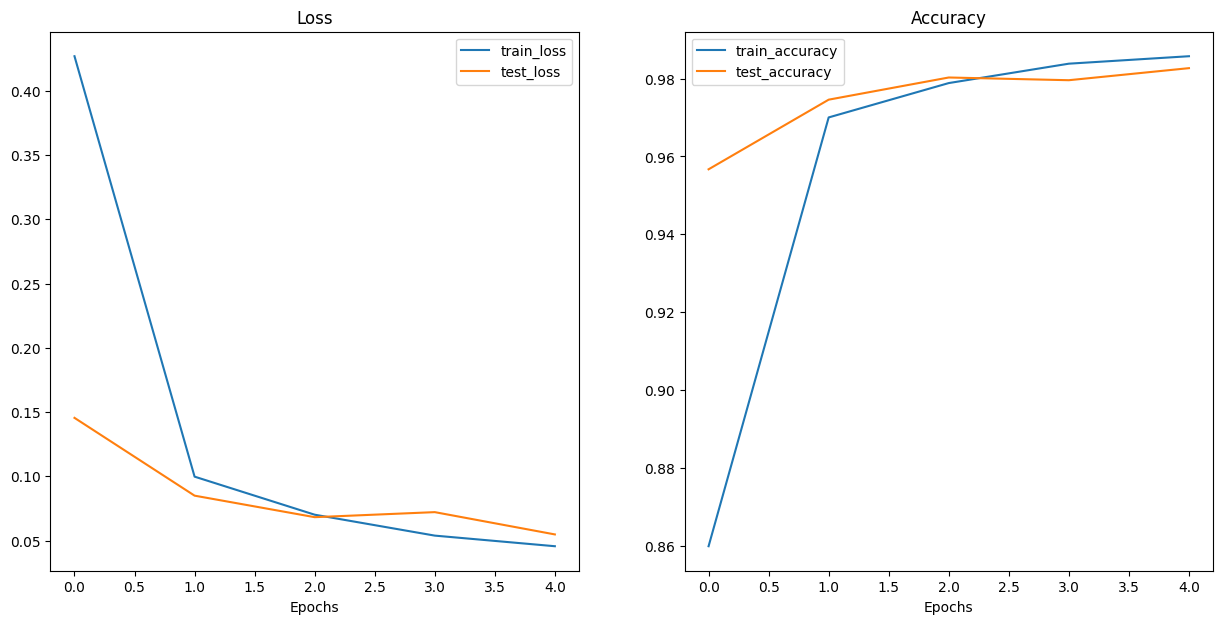

In [12]:
def plot_loss_curves(results):

    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_results)

# Draft Cells

In [13]:
torch.manual_seed(42)
z = torch.randn(size=(32, 40))
y = z.clone()
x = z + y
x = x.squeeze()
x1, x2, x3, x4 = x.chunk(4, 1)
x.shape, x1.shape, x2.shape, x3.shape, x4.shape

(torch.Size([32, 40]),
 torch.Size([32, 10]),
 torch.Size([32, 10]),
 torch.Size([32, 10]),
 torch.Size([32, 10]))

In [14]:
torch.manual_seed(42)
x = torch.randn(size=(32, 40))
z = x.size(0)
z

32

In [15]:
# Understanding the view method used in LSTMCell
test = img.view(-1, 28, 28)
test.shape, test.dtype

(torch.Size([100, 28, 28]), torch.float32)